In [1]:

import datetime
import numpy as np
import cv2
from itertools import cycle
import pickle
import pathlib
import math
import tqdm
import scipy.io
from matplotlib import pyplot as plt
import scipy.io
import h5py
import re
from lxml import etree as ET
import scipy.signal as sig
import pandas as pd
from scipy.stats import kde
from BlockSync_current import BlockSync
import UtilityFunctions_newOE as uf
from scipy import signal
import bokeh
import seaborn as sns
from matplotlib import rcParams
%matplotlib inline
plt.style.use('default')
rcParams['pdf.fonttype'] = 42  # Ensure fonts are embedded and editable
rcParams['ps.fonttype'] = 42  # Ensure compatibility with vector outputs




def bokeh_plotter(data_list, x_axis_list=None, label_list=None,
                  plot_name='default',
                  x_axis_label='X', y_axis_label='Y',
                  peaks=None, peaks_list=False, export_path=False):
    """Generates an interactive Bokeh plot for the given data vector.
    Args:
        data_list (list or array): The data to be plotted.
        label_list (list of str): The labels of the data vectors
        plot_name (str, optional): The title of the plot. Defaults to 'default'.
        x_axis (str, optional): The label for the x-axis. Defaults to 'X'.
        y_axis (str, optional): The label for the y-axis. Defaults to 'Y'.
        peaks (list or array, optional): Indices of peaks to highlight on the plot. Defaults to None.
        export_path (False or str): when set to str, will output the resulting html fig
    """
    color_cycle = cycle(bokeh.palettes.Category10_10)
    fig = bokeh.plotting.figure(title=f'bokeh explorer: {plot_name}',
                                x_axis_label=x_axis_label,
                                y_axis_label=y_axis_label,
                                plot_width=1500,
                                plot_height=700)

    for i, data_vector in enumerate(data_list):

        color = next(color_cycle)

        if x_axis_list is None:
            x_axis = range(len(data_vector))
        elif len(x_axis_list) == len(data_list):
            print('x_axis manually set')
            x_axis = x_axis_list[i]
        else:
            raise Exception('problem with x_axis_list input - should be either None, or a list with the same length as data_list')
        if label_list is None:
            fig.line(x_axis, data_vector, line_color=color, legend_label=f"Line {i+1}")
        elif len(label_list) == len(data_list):
            fig.line(range(len(data_vector)), data_vector, line_color=color, legend_label=f"{label_list[i]}")
        if peaks is not None and peaks_list is True:
            fig.circle(peaks[i], data_vector[peaks[i]], size=10, color=color)

    if peaks is not None and peaks_list is False:
        fig.circle(peaks, data_vector[peaks], size=10, color='red')

    if export_path is not False:
        print(f'exporting to {export_path}')
        bokeh.io.output.output_file(filename=str(export_path / f'{plot_name}.html'), title=f'{plot_name}')
    bokeh.plotting.show(fig)


def load_eye_data_2d_w_rotation_matrix(block):
    """
    This function checks if the eye dataframes and rotation dict object exist, then imports them
    :param block: The current blocksync class with verifiec re/le dfs
    :return: None
    """
    try:
        block.left_eye_data = pd.read_csv(block.analysis_path / 'left_eye_data.csv', index_col=0, engine='python')
        block.right_eye_data = pd.read_csv(block.analysis_path / 'right_eye_data.csv', index_col=0, engine='python')
    except FileNotFoundError:
        print('eye_data files not found, run the pipeline!')
        return

    try:
        with open(block.analysis_path / 'rotate_eye_data_params.pkl', 'rb') as file:
            rotation_dict = pickle.load(file)
            block.left_rotation_matrix = rotation_dict['left_rotation_matrix']
            block.right_rotation_matrix = rotation_dict['right_rotation_matrix']
            block.left_rotation_angle = rotation_dict['left_rotation_angle']
            block.right_rotation_angle = rotation_dict['right_rotation_angle']
    except FileNotFoundError:
        print('No rotation matrix file, create it')





In [2]:

# create a multi-animal block_collection:

def create_block_collections(animals, block_lists, experiment_path, bad_blocks=None):
    """
    Create block collections and a block dictionary from multiple animals and their respective block lists.

    Parameters:
    - animals: list of str, names of the animals.
    - block_lists: list of lists of int, block numbers corresponding to each animal.
    - experiment_path: pathlib.Path, path to the experiment directory.
    - bad_blocks: list of int, blocks to exclude. Default is an empty list.

    Returns:
    - block_collection: list of BlockSync objects for all specified blocks.
    - block_dict: dictionary where keys are block numbers as strings and values are BlockSync objects.
    """
    import UtilityFunctions_newOE as uf

    if bad_blocks is None:
        bad_blocks = []

    block_collection = []
    block_dict = {}

    for animal, blocks in zip(animals, block_lists):
        # Generate blocks for the current animal
        current_blocks = uf.block_generator(
            block_numbers=blocks,
            experiment_path=experiment_path,
            animal=animal,
            bad_blocks=bad_blocks
        )
        # Add to collection and dictionary
        block_collection.extend(current_blocks)
        for b in current_blocks:
            block_dict[f"{animal}_block_{b.block_num}"] = b

    return block_collection, block_dict






In [3]:

animals = ['PV_106','PV_143','PV_62','PV_126', 'PV_57']
block_lists = [[8,9,10,11,12],[1,2,3,4],[24, 26, 38],[7, 8, 9, 10, 11, 12], [7, 8, 9, 12, 13]]

experiment_path = pathlib.Path(r"Z:\Nimrod\experiments")
bad_blocks = [0]  # Example of bad blocks

block_collection, block_dict = create_block_collections(
    animals=animals,
    block_lists=block_lists,
    experiment_path=experiment_path,
    bad_blocks=bad_blocks)

instantiated block number 008 at Path: Z:\Nimrod\experiments\PV_106\2025_08_06\block_008, new OE version
Found the sample rate for block 008 in the xml file, it is 20000 Hz
created the .oe_rec attribute as an open ephys recording obj with get_data functionality
retrieving zertoh sample number for block 008
got it!
instantiated block number 009 at Path: Z:\Nimrod\experiments\PV_106\2025_08_06\block_009, new OE version
Found the sample rate for block 009 in the xml file, it is 20000 Hz
created the .oe_rec attribute as an open ephys recording obj with get_data functionality
retrieving zertoh sample number for block 009
got it!
instantiated block number 010 at Path: Z:\Nimrod\experiments\PV_106\2025_08_06\block_010, new OE version
Found the sample rate for block 010 in the xml file, it is 20000 Hz
created the .oe_rec attribute as an open ephys recording obj with get_data functionality
retrieving zertoh sample number for block 010
got it!
instantiated block number 011 at Path: Z:\Nimrod\exp

In [4]:
for block in block_collection:
    block.parse_open_ephys_events()
    block.get_eye_brightness_vectors()
    block.synchronize_block()
    block.create_eye_brightness_df(threshold_value=20)

    # if the code fails here, go to manual synchronization
    block.import_manual_sync_df()
    block.read_dlc_data()
    block.calibrate_pixel_size(10)
    load_eye_data_2d_w_rotation_matrix(block) #should be integrated again... later

# # NOTICE THE DIRECTIONALITY FLIP!!!
#     block.left_eye_data = horizontal_flip_eye_data(block.left_eye_data.copy(),640)
#     block.right_eye_data = horizontal_flip_eye_data(block.right_eye_data.copy(),640)
    # calibrate pupil diameter:
for block in block_collection:
    block.left_eye_data = pd.read_csv(block.analysis_path / f'left_eye_data_degrees_raw_verified.csv')
    block.right_eye_data = pd.read_csv(block.analysis_path / 'right_eye_data_degrees_raw_verified.csv')



running parse_open_ephys_events...
block 008 has a parsed events file, reading...
Getting eye brightness values for block 008...
Found an existing file!
Eye brightness vectors generation complete.
blocksync_df loaded from analysis folder
eye_brightness_df loaded from analysis folder
eye dataframes loaded from analysis folder
got the calibration values from the analysis folder
running parse_open_ephys_events...
block 009 has a parsed events file, reading...
Getting eye brightness values for block 009...
Found an existing file!
Eye brightness vectors generation complete.
blocksync_df loaded from analysis folder
eye_brightness_df loaded from analysis folder
eye dataframes loaded from analysis folder
got the calibration values from the analysis folder
running parse_open_ephys_events...
block 010 has a parsed events file, reading...
Getting eye brightness values for block 010...
Found an existing file!
Eye brightness vectors generation complete.
blocksync_df loaded from analysis folder
eye_

In [5]:
 for block in block_collection:
    if 'pupil_diameter' not in block.left_eye_data.columns:
        block.left_eye_data['pupil_diameter_pixels'] = block.left_eye_data.major_ax
        block.right_eye_data['pupil_diameter_pixels'] = block.right_eye_data.major_ax
        block.left_eye_data['pupil_diameter'] = block.left_eye_data['pupil_diameter_pixels'] * block.L_pix_size
        block.right_eye_data['pupil_diameter'] = block.right_eye_data['pupil_diameter_pixels'] * block.R_pix_size

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pathlib, datetime, pickle, re

plt.style.use('default')
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype']  = 42

def plot_rest_positions_phi_theta_scatter(
    block_dict,
    eyes=('L','R'),                 # which eyes to include
    rest_filter=True,               # restrict to low-movement epochs
    speed_quantile=0.20,            # keep slowest X% frames per block/eye
    min_segment_ms=250,             # require contiguous low-speed segments ≥ this duration
    dispersion='MAD',               # 'MAD' (scaled) or 'IQR' for error bars
    per_row_figsize=(4.2, 4.2),     # size per subplot (w,h)
    xlim=None, ylim=None,           # manual axes limits in deg (tuple) or None to auto
    zero_lines=True,                # draw 0° reference lines
    tight=True,                     # tight_layout at the end
    export_path=None                # directory to export PDF + PKL (timestamped subfolder)
):
    """
    For each animal and each eye, plot per-block resting position as a scatter point in (k_phi, k_theta)
    with horizontal and vertical error bars (dispersion). Colors encode blocks.

    Returns
    -------
    summary_df : pd.DataFrame
        Columns: [animal, block, eye, n_frames, k_phi_med, k_theta_med, k_phi_disp, k_theta_disp, disp_metric]
    fig : matplotlib.figure.Figure
    """
    def _get_animal_block_from_key(key, block_obj):
        if '_block_' in key:
            animal = key.split('_block_')[0]
            block = key.split('_block_')[1]
        else:
            animal = getattr(block_obj, 'animal_call', 'NA')
            block  = str(getattr(block_obj, 'block_num', 'NA'))
        return animal, block

    def _ensure_timebase(df, block_obj):
        if 'ms_axis' in df.columns:
            return df['ms_axis'].to_numpy(float)
        # try reconstruct from OE timestamp if available
        if 'OE_timestamp' in df.columns and hasattr(block_obj, 'sample_rate') and block_obj.sample_rate:
            return (df['OE_timestamp'].to_numpy(float) / (block_obj.sample_rate/1000.0))
        # fallback ~60 Hz
        n = len(df)
        return np.arange(n, dtype=float) * 1000.0/60.0

    def _angular_speed(phi, theta, t_ms):
        # deg/s magnitude
        # basic interpolation to fill tiny gaps for diff stability
        phi_i = pd.Series(phi).interpolate(limit_direction='both').to_numpy()
        th_i  = pd.Series(theta).interpolate(limit_direction='both').to_numpy()
        dt = np.diff(t_ms, prepend=np.nan)  # ms
        if np.isnan(dt[0]) and np.isfinite(dt[1:]).any():
            dt[0] = np.nanmedian(dt[1:])
        dphi = np.diff(phi_i,   prepend=phi_i[0])
        dth  = np.diff(th_i,    prepend=th_i[0])
        v = np.sqrt(dphi*dphi + dth*dth) / (dt/1000.0)
        return v

    def _low_movement_mask(t_ms, v, speed_q, min_ms):
        if not np.isfinite(v).any():
            return np.zeros_like(v, dtype=bool)
        thr = np.nanquantile(v, speed_q)
        base = (v <= thr) & np.isfinite(v)
        idx = np.where(base)[0]
        if idx.size == 0:
            return np.zeros_like(base, dtype=bool)
        # contiguous segments of indices
        breaks = np.where(np.diff(idx) > 1)[0]
        starts = np.r_[0, breaks+1]
        ends   = np.r_[breaks, len(idx)-1]
        keep = np.zeros_like(base, dtype=bool)
        for s, e in zip(starts, ends):
            seg = idx[s:e+1]
            dur = t_ms[seg[-1]] - t_ms[seg[0]]
            if dur >= min_ms:
                keep[seg] = True
        return keep

    def _robust(x, how='MAD'):
        x = x[np.isfinite(x)]
        if x.size == 0:
            return np.nan, np.nan
        med = np.nanmedian(x)
        if how.upper() == 'MAD':
            disp = 1.4826 * np.nanmedian(np.abs(x - med))
        else:
            q1, q3 = np.nanquantile(x, [0.25, 0.75])
            disp = 0.5*(q3 - q1)  # semi-IQR for symmetric-looking error bars
        return med, disp

    # gather data per (animal, block, eye)
    rows = []
    animals_order = []
    # Also collect per-animal block sets to assign colors consistently within each animal
    blocks_per_animal_eye = {}

    for key, block in block_dict.items():
        for eye in eyes:
            df = getattr(block, 'left_eye_data' if eye=='L' else 'right_eye_data', None)
            if df is None or df.empty:
                continue
            if not {'k_phi','k_theta'}.issubset(df.columns):
                # skip if required metrics are missing
                continue
            animal, block_num = _get_animal_block_from_key(key, block)

            phi = df['k_phi'].to_numpy(float)
            th  = df['k_theta'].to_numpy(float)
            tms = _ensure_timebase(df, block)

            finite_mask = np.isfinite(phi) & np.isfinite(th)
            v = _angular_speed(phi, th, tms)
            keep = finite_mask
            if rest_filter:
                keep = finite_mask & _low_movement_mask(tms, v, speed_quantile, min_segment_ms)

            n_frames = int(np.sum(keep))
            if n_frames == 0:
                continue

            phi_med, phi_disp = _robust(phi[keep], dispersion)
            th_med,  th_disp  = _robust(th[keep],  dispersion)

            rows.append(dict(
                animal=animal, block=str(block_num), eye=eye, n_frames=n_frames,
                k_phi_med=phi_med, k_theta_med=th_med,
                k_phi_disp=phi_disp, k_theta_disp=th_disp,
                disp_metric=dispersion.upper()
            ))
            blocks_per_animal_eye.setdefault((animal, eye), []).append(str(block_num))
            if animal not in animals_order:
                animals_order.append(animal)

    summary_df = pd.DataFrame(rows)
    if summary_df.empty:
        raise RuntimeError("No usable (k_phi, k_theta) data found after filtering. "
                           "Check that k_phi/k_theta exist and rest_filter params aren’t too strict.")

    # sort blocks numerically where possible
    def _num_key(b):
        return int(re.sub(r'[^0-9]', '', b)) if any(c.isdigit() for c in b) else b
    for k in list(blocks_per_animal_eye.keys()):
        blocks_per_animal_eye[k] = sorted(list(set(blocks_per_animal_eye[k])), key=_num_key)

    # figure grid: one row per animal, two columns for eyes present
    eyes_present = [e for e in eyes if (summary_df['eye']==e).any()]
    n_rows = len(animals_order)
    n_cols = len(eyes_present)
    fig_w = per_row_figsize[0] * n_cols
    fig_h = per_row_figsize[1] * n_rows
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(fig_w, fig_h), squeeze=False)

    # plot
    for r, animal in enumerate(animals_order):
        for c, eye in enumerate(eyes_present):
            ax = axes[r, c]
            sub = summary_df[(summary_df['animal']==animal) & (summary_df['eye']==eye)]
            if sub.empty:
                ax.axis('off'); continue

            # color map per block within this (animal, eye)
            blist = blocks_per_animal_eye.get((animal, eye), sorted(sub['block'].unique(), key=_num_key))
            palette = sns.color_palette('tab20', n_colors=max(3, len(blist)))
            color_map = {b: palette[i % len(palette)] for i, b in enumerate(blist)}

            # draw points + orthogonal errorbars
            for _, row in sub.sort_values('block', key=lambda s: s.map(_num_key)).iterrows():
                x = row['k_phi_med'];  y = row['k_theta_med']
                xerr = row['k_phi_disp']; yerr = row['k_theta_disp']
                col = color_map[row['block']]
                ax.errorbar(x, y, xerr=xerr, yerr=yerr,
                            fmt='o', ms=6, capsize=3, color=col, ecolor=col, elinewidth=1.5, alpha=0.95)
                # optional small label: block id next to point (comment out if cluttered)
                # ax.text(x, y, str(row['block']), fontsize=7, color=col, ha='left', va='bottom')

            ax.set_title(f"{animal} — {'Left' if eye=='L' else 'Right'} eye  "
                         f"(disp={dispersion.upper()}, n={int(sub['n_frames'].sum())} frames kept)")
            ax.set_xlabel("k_phi (deg)")
            ax.set_ylabel("k_theta (deg)")
            if zero_lines:
                ax.axvline(0, ls=':', lw=0.8, color='k', alpha=0.5)
                ax.axhline(0, ls=':', lw=0.8, color='k', alpha=0.5)
            ax.set_aspect('equal', adjustable='box')
            if xlim: ax.set_xlim(*xlim)
            if ylim: ax.set_ylim(*ylim)
            ax.grid(True, ls=':', alpha=0.25)

            # make a compact color swatch legend placeholder (labels later if you want full legend)
            # Here we place a small legend with block IDs:
            handles = [plt.Line2D([0],[0], marker='o', color=color_map[b], lw=0, label=str(b)) for b in blist]
            leg = ax.legend(handles=handles, title="Block", fontsize=7, loc='best', frameon=False)
            if leg and leg.get_title():
                leg.get_title().set_fontsize(8)

    if tight:
        plt.tight_layout()

    # Export (timestamped folder)
    if export_path:
        export_path = pathlib.Path(export_path)
        ts = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M")
        outdir = export_path / f"{ts}_Resting_kphi_ktheta_scatter"
        outdir.mkdir(parents=True, exist_ok=True)
        pdf = outdir / f"{ts}_rest_kphi_ktheta_scatter.pdf"
        fig.savefig(pdf, bbox_inches='tight', dpi=300)
        pkl = outdir / f"{ts}_rest_kphi_ktheta_summary.pkl"
        with open(pkl, 'wb') as f:
            pickle.dump(dict(summary_df=summary_df), f)
        print(f"Exported figure to {pdf}")
        print(f"Exported data to {pkl}")

    return summary_df, fig


,animal,block,eye,n_frames,k_phi_med,k_theta_med,k_phi_disp,k_theta_disp,disp_metric
0,PV_106,008,L,12,-7.745277,-41.538292,8.100772,3.823162,MAD
1,PV_106,008,R,10,6.551823,-39.866869,4.274220,2.832292,MAD
2,PV_106,009,L,26,-16.056225,-41.440647,3.962951,4.559723,MAD
3,PV_106,009,R,12,27.592441,-31.164500,5.809651,2.218184,MAD
4,PV_106,010,L,18,-6.255930,-46.358009,9.222900,5.210874,MAD


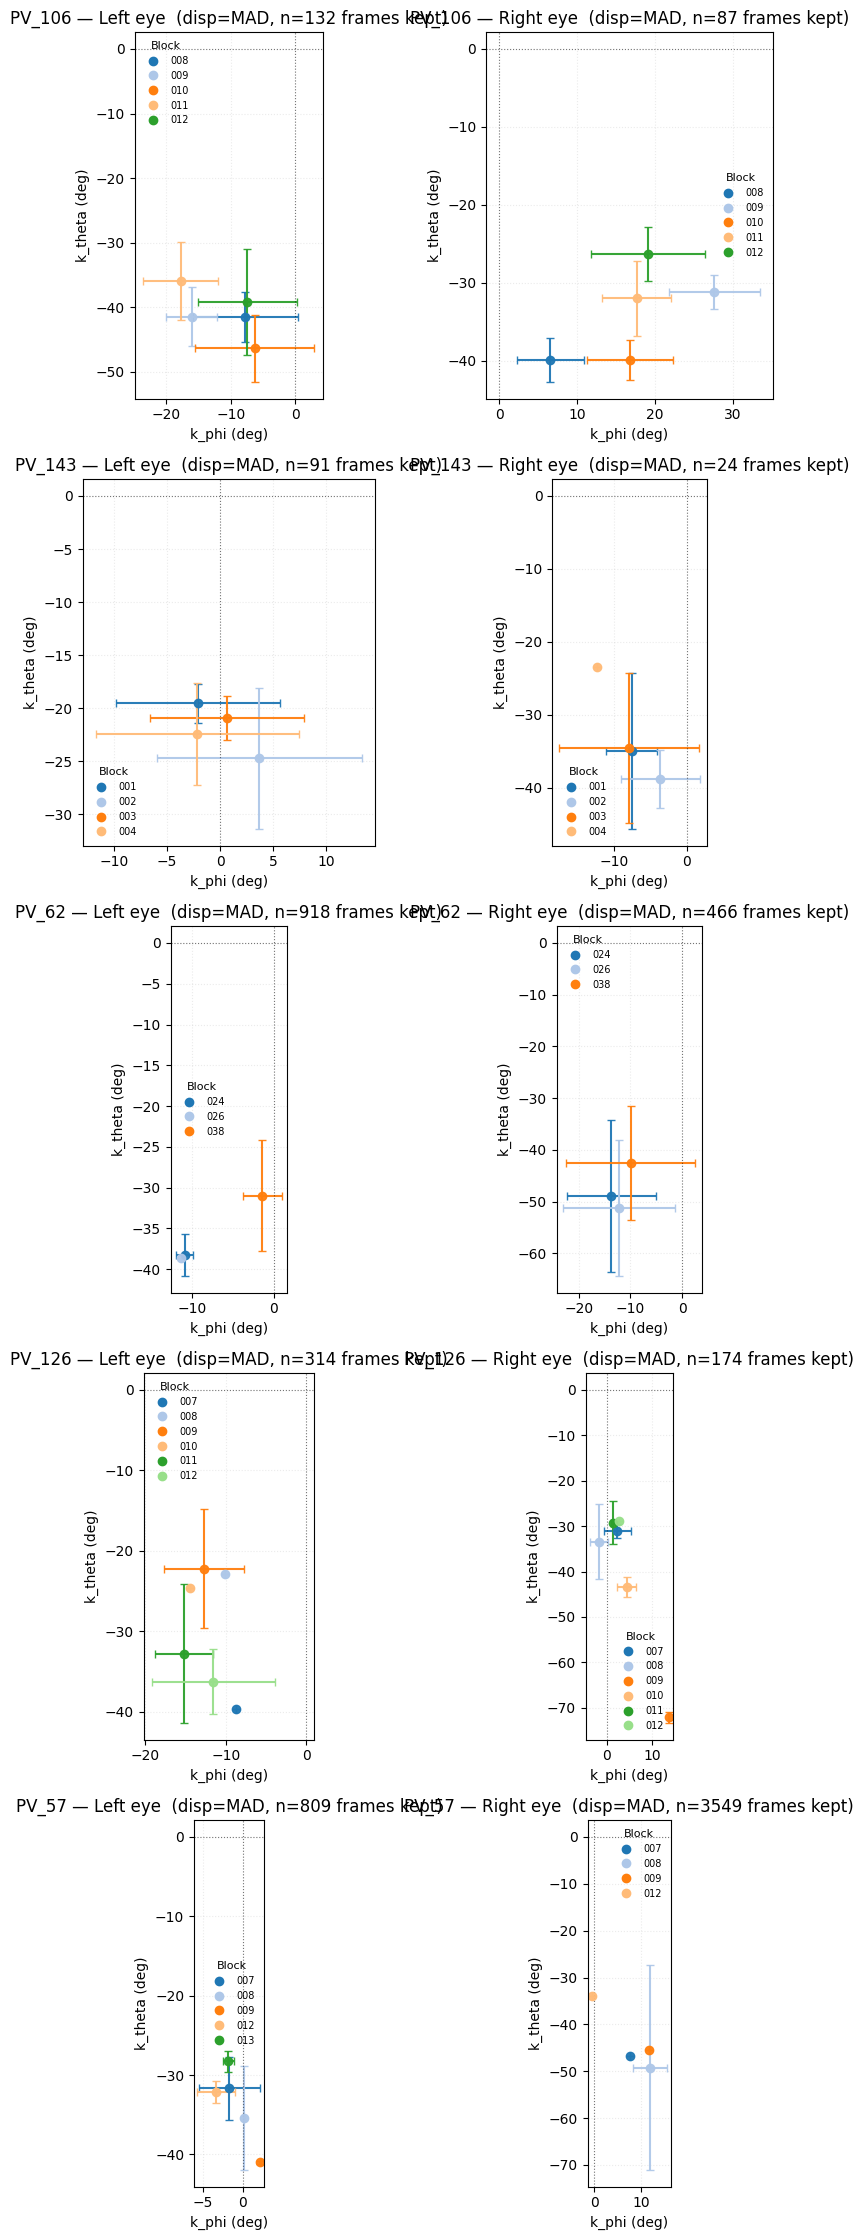

In [9]:
summary_df, fig = plot_rest_positions_phi_theta_scatter(
    block_dict,
    eyes=('L','R'),
    rest_filter=True,
    speed_quantile=0.20,     # slowest 20% frames (per block/eye)
    min_segment_ms=250,      # require ≥250 ms contiguous rest
    dispersion='MAD',        # or 'IQR'
    per_row_figsize=(4.5,4.5),
    xlim=None, ylim=None,
    export_path=None         # e.g., pathlib.Path(r"Z:\Nimrod\exports")
)
display(summary_df.head())
plt.show()


In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pathlib, datetime, pickle, re, cv2, textwrap

plt.style.use('default')
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype']  = 42

def plot_rest_positions_phi_theta_scatter_with_frames(
    block_dict,
    eyes=('L','R'),
    rest_filter=True,
    speed_quantile=0.20,
    min_segment_ms=250,
    dispersion='MAD',            # 'MAD' or 'IQR' (semi-IQR for bars)
    per_plot_size=(4.6, 4.6),    # size of each scatter panel (w,h)
    zero_lines=True,
    export_path=None,
    # frame rendering options
    include_frames=True,
    frame_strategy='median_rest', # 'median_rest' or 'first_rest'
    max_blocks_images=None,       # None for all; else cap per-animal to avoid huge figures
    frame_read_attempts=('left_eye_video_path','left_video_path','left_vid_path','left_vid',
                         'right_eye_video_path','right_video_path','right_vid_path','right_vid'),
    frame_scale=1.0,              # scale images (relative to automatic layout)
    frame_aspect=(4,3),           # hint for tile aspect (w,h) used to size axes
    annotate_block_on_scatter=True
):
    """
    For each animal and eye:
      • Scatter (k_phi, k_theta) per block: point=median, errorbars = axis-wise dispersion
      • Below: image tiles — for each block, Left frame then Right frame, labeled.

    Returns
    -------
    summary_df : tidy table with per-block medians/dispersion
    fig : matplotlib.figure.Figure
    """

    # ---------------- helpers ----------------
    def _get_animal_block_from_key(key, block_obj):
        if '_block_' in key:
            animal = key.split('_block_')[0]
            block = key.split('_block_')[1]
        else:
            animal = getattr(block_obj, 'animal_call', 'NA')
            block  = str(getattr(block_obj, 'block_num', 'NA'))
        return animal, block

    def _ensure_timebase(df, block_obj):
        if 'ms_axis' in df.columns:
            return df['ms_axis'].to_numpy(float)
        if 'OE_timestamp' in df.columns and hasattr(block_obj, 'sample_rate') and block_obj.sample_rate:
            return df['OE_timestamp'].to_numpy(float) / (block_obj.sample_rate/1000.0)
        # fallback ~60 Hz
        n = len(df)
        return np.arange(n, dtype=float) * (1000.0/60.0)

    def _angular_speed(phi, theta, t_ms):
        phi_i = pd.Series(phi).interpolate(limit_direction='both').to_numpy()
        th_i  = pd.Series(theta).interpolate(limit_direction='both').to_numpy()
        dt = np.diff(t_ms, prepend=np.nan)
        if np.isnan(dt[0]) and np.isfinite(dt[1:]).any():
            dt[0] = np.nanmedian(dt[1:])
        dphi = np.diff(phi_i, prepend=phi_i[0])
        dth  = np.diff(th_i,  prepend=th_i[0])
        v = np.sqrt(dphi*dphi + dth*dth) / (dt/1000.0)  # deg/s
        return v

    def _low_movement_mask(t_ms, v, speed_q, min_ms):
        if not np.isfinite(v).any():
            return np.zeros_like(v, dtype=bool)
        thr = np.nanquantile(v, speed_q)
        base = (v <= thr) & np.isfinite(v)
        idx = np.where(base)[0]
        if idx.size == 0:
            return np.zeros_like(base, dtype=bool)
        breaks = np.where(np.diff(idx) > 1)[0]
        starts = np.r_[0, breaks+1]
        ends   = np.r_[breaks, len(idx)-1]
        keep = np.zeros_like(base, dtype=bool)
        for s, e in zip(starts, ends):
            seg = idx[s:e+1]
            dur = t_ms[seg[-1]] - t_ms[seg[0]]
            if dur >= min_ms:
                keep[seg] = True
        return keep

    def _robust(x, how='MAD'):
        x = x[np.isfinite(x)]
        if x.size == 0:
            return np.nan, np.nan
        med = np.nanmedian(x)
        if how.upper() == 'MAD':
            disp = 1.4826 * np.nanmedian(np.abs(x - med))
        else:
            q1, q3 = np.nanquantile(x, [0.25, 0.75])
            disp = 0.5*(q3 - q1)
        return med, disp

    def _num_key(b):
        return int(re.sub(r'[^0-9]', '', b)) if any(c.isdigit() for c in b) else b

    def _get_video_path(block_obj, which_eye):
        # search likely attribute names
        names = frame_read_attempts
        if which_eye == 'L':
            candidates = [n for n in names if n.startswith('left')]
        else:
            candidates = [n for n in names if n.startswith('right')]
        for nm in candidates:
            if hasattr(block_obj, nm):
                p = getattr(block_obj, nm)
                if p is None:
                    continue
                p = pathlib.Path(p)
                if p.exists():
                    return str(p)
        # try analysis_path common filenames
        if hasattr(block_obj, 'analysis_path'):
            ap = pathlib.Path(block_obj.analysis_path)
            fallbacks = ['left_eye.mp4','left_eye.avi','L_eye.avi','L_eye.mp4'] if which_eye=='L' else \
                        ['right_eye.mp4','right_eye.avi','R_eye.avi','R_eye.mp4']
            for fn in fallbacks:
                if (ap/fn).exists():
                    return str(ap/fn)
        return None

    def _grab_frame_at_ms(video_path, t_ms):
        if video_path is None:
            return None
        cap = cv2.VideoCapture(video_path)
        if not cap.isOpened():
            return None
        fps = cap.get(cv2.CAP_PROP_FPS) or 0.0
        if fps <= 0.0:
            fps = 60.0
        frame_idx = int(max(0, round((t_ms/1000.0) * fps)))
        total = int(cap.get(cv2.CAP_PROP_FRAME_COUNT) or 0)
        if total > 0:
            frame_idx = min(frame_idx, total-1)
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
        ok, frame = cap.read()
        cap.release()
        if not ok or frame is None:
            return None
        # BGR->RGB
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        return frame

    def _placeholder_tile(text, size=(200,150)):
        # make a simple placeholder RGB image with text
        W,H = size
        img = np.full((H,W,3), 240, dtype=np.uint8)
        return img

    # -------------- aggregate per-block medians + dispersion + rest timestamps --------------
    rows = []
    animals_order, eyes_present = [], []
    kept_times = {}  # (animal, block, eye) -> representative t_ms for frame extraction
    blocks_per_animal = {}

    for key, block in block_dict.items():
        for eye in eyes:
            df = getattr(block, 'left_eye_data' if eye=='L' else 'right_eye_data', None)
            if df is None or df.empty or not {'k_phi','k_theta'}.issubset(df.columns):
                continue

            animal, block_num = _get_animal_block_from_key(key, block)
            phi = df['k_phi'].to_numpy(float)
            th  = df['k_theta'].to_numpy(float)
            tms = _ensure_timebase(df, block)
            finite = np.isfinite(phi) & np.isfinite(th)
            v = _angular_speed(phi, th, tms)
            keep = finite
            if rest_filter:
                keep = finite & _low_movement_mask(tms, v, speed_quantile, min_segment_ms)
            if not keep.any():
                continue

            phi_med, phi_disp = _robust(phi[keep], dispersion)
            th_med,  th_disp  = _robust(th[keep],  dispersion)

            # representative time for frame extraction
            if frame_strategy == 'median_rest':
                kept_t = np.nanmedian(tms[keep])
            else:
                kept_t = np.nanmin(tms[keep])

            rows.append(dict(
                animal=animal, block=str(block_num), eye=eye,
                k_phi_med=phi_med, k_theta_med=th_med,
                k_phi_disp=phi_disp, k_theta_disp=th_disp,
                n_frames=int(keep.sum()), rep_t_ms=float(kept_t),
                disp_metric=dispersion.upper()
            ))
            kept_times[(animal, str(block_num), eye)] = float(kept_t)
            blocks_per_animal.setdefault(animal, set()).add(str(block_num))
            if animal not in animals_order: animals_order.append(animal)
            if eye not in eyes_present: eyes_present.append(eye)

    summary_df = pd.DataFrame(rows)
    if summary_df.empty:
        raise RuntimeError("No usable k_phi/k_theta data after filtering. "
                           "Check columns and rest_filter strictness.")

    # -------- global axis span (equal for everyone) from medians ± dispersion --------
    x_lo = (summary_df['k_phi_med'] - summary_df['k_phi_disp']).min()
    x_hi = (summary_df['k_phi_med'] + summary_df['k_phi_disp']).max()
    y_lo = (summary_df['k_theta_med'] - summary_df['k_theta_disp']).min()
    y_hi = (summary_df['k_theta_med'] + summary_df['k_theta_disp']).max()
    # symmetric, same range both axes (so 1 unit means same everywhere)
    max_abs = float(np.nanmax(np.abs([x_lo, x_hi, y_lo, y_hi])))
    pad = max(1.0, 0.05*max_abs)  # small padding
    lim = (-max_abs - pad, max_abs + pad)

    # -------- figure layout per animal --------
    # We build a tall figure: for each animal we allocate:
    #   row A: two scatter panels (L, R)
    #   row B: a tile row of images: for each block [L, R] frames
    # Total height depends on number of animals and blocks.
    # First, compute how many blocks per animal (cap for images if requested)
    blocks_per_animal = {a: sorted(list(bset), key=_num_key) for a,bset in blocks_per_animal.items()}

    # Estimate figure size
    n_animals = len(animals_order)
    # Height per animal: scatter row + image row
    scatter_h = per_plot_size[1]
    img_h = per_plot_size[1]*0.75 if include_frames else 0.0
    total_h = n_animals*(scatter_h + img_h) + 0.6*n_animals
    total_w = max(2*per_plot_size[0], 10.0)

    fig = plt.figure(figsize=(total_w, total_h), dpi=150)
    outer_gs = fig.add_gridspec(nrows=n_animals, ncols=1, hspace=0.6)

    for ai, animal in enumerate(animals_order):
        # Sub-gridspec for this animal: 2 rows (scatter, images)
        sub_gs = outer_gs[ai].subgridspec(nrows=2 if include_frames else 1, ncols=1, height_ratios=[1, 0.9] if include_frames else [1])

        # ---- Scatter row (two columns: L & R if present) ----
        eyes_in_animal = [e for e in eyes_present if ((summary_df['animal']==animal)&(summary_df['eye']==e)).any()]
        n_sc_cols = len(eyes_in_animal)
        sc_gs = sub_gs[0].subgridspec(nrows=1, ncols=n_sc_cols, wspace=0.25)
        # color palette per animal to keep block colors consistent across both eyes
        blist = blocks_per_animal.get(animal, [])
        if max_blocks_images is not None:
            blist = blist[:max_blocks_images]
        palette = sns.color_palette('tab20', n_colors=max(3, len(blist)))
        color_map = {b: palette[i % len(palette)] for i, b in enumerate(blist)}

        for ci, eye in enumerate(eyes_in_animal):
            ax = fig.add_subplot(sc_gs[0, ci])
            sub = summary_df[(summary_df['animal']==animal)&(summary_df['eye']==eye)]
            # restrict to shown blocks if capped for images (keeps color consistency)
            if max_blocks_images is not None:
                sub = sub[sub['block'].isin(blist)]

            # plot points + error bars
            for _, row in sub.sort_values('block', key=lambda s: s.map(_num_key)).iterrows():
                x = row['k_phi_med']; y = row['k_theta_med']
                xerr = row['k_phi_disp']; yerr = row['k_theta_disp']
                col = color_map.get(row['block'], (0.3,0.3,0.3))
                ax.errorbar(x, y, xerr=xerr, yerr=yerr,
                            fmt='o', ms=6, capsize=3, color=col, ecolor=col, elinewidth=1.3, alpha=0.95)
                if annotate_block_on_scatter:
                    ax.text(x, y, str(row['block']), fontsize=7, color=col, ha='left', va='bottom')

            ax.set_title(f"{animal} — {'Left' if eye=='L' else 'Right'} eye  "
                         f"(disp={dispersion.upper()})",
                         fontsize=10)
            ax.set_xlabel("k_phi (deg)"); ax.set_ylabel("k_theta (deg)")
            if zero_lines:
                ax.axvline(0, ls=':', lw=0.8, color='k', alpha=0.5)
                ax.axhline(0, ls=':', lw=0.8, color='k', alpha=0.5)
            ax.set_xlim(lim); ax.set_ylim(lim)
            ax.set_aspect('equal', adjustable='box')
            ax.grid(True, ls=':', alpha=0.25)

            # lightweight legend with block IDs (color swatches)
            handles = [plt.Line2D([0],[0], marker='o', color=color_map[b], lw=0, label=str(b)) for b in blist if b in sub['block'].values]
            if handles:
                leg = ax.legend(handles=handles, title="Block", fontsize=7, loc='best', frameon=False)
                if leg and leg.get_title(): leg.get_title().set_fontsize(8)

        # ---- Images row: [L frame, R frame] for each block ----
        if include_frames:
            # visible blocks (respect cap)
            blocks_for_images = blist
            n_tiles = max(1, 2*len(blocks_for_images))  # two per block
            # compute columns so tiles don't get too tiny
            cols = n_tiles
            img_gs = sub_gs[1].subgridspec(nrows=1, ncols=cols, wspace=0.05)
            # tile order: for each block -> L then R
            tile_idx = 0
            for b in blocks_for_images:
                for eye in ['L','R']:
                    ax_img = fig.add_subplot(img_gs[0, tile_idx])
                    tile_idx += 1
                    # pick representative time
                    t_ms = kept_times.get((animal, b, eye), None)
                    # load frame
                    block_obj = None
                    # find the block object back
                    # (iterate keys only within this animal and matching block)
                    for key, blk in block_dict.items():
                        a2, b2 = _get_animal_block_from_key(key, blk)
                        if a2==animal and str(b2)==str(b):
                            block_obj = blk; break
                    if block_obj is None:
                        img = _placeholder_tile("no block")
                    else:
                        vpath = _get_video_path(block_obj, 'L' if eye=='L' else 'R')
                        if t_ms is None:
                            img = _placeholder_tile("no rest time")
                        else:
                            img = _grab_frame_at_ms(vpath, t_ms)
                            if img is None:
                                txt = f"no frame\n{pathlib.Path(vpath).name if vpath else 'no video'}"
                                img = _placeholder_tile(txt)
                    # show image
                    ax_img.imshow(img)
                    ax_img.set_xticks([]); ax_img.set_yticks([])
                    title = f"Block {b} — {'Left' if eye=='L' else 'Right'}"
                    ax_img.set_title(title, fontsize=8, color=color_map.get(b,(0.2,0.2,0.2)))
                    for spine in ax_img.spines.values():
                        spine.set_visible(True); spine.set_linewidth(0.6)
                        spine.set_edgecolor(color_map.get(b,(0.4,0.4,0.4)))

    plt.tight_layout()

    # -------- export --------
    if export_path:
        export_path = pathlib.Path(export_path)
        ts = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M")
        outdir = export_path / f"{ts}_Rest_kphi_ktheta_scatter_with_frames"
        outdir.mkdir(parents=True, exist_ok=True)
        pdf = outdir / f"{ts}_rest_kphi_ktheta_scatter_with_frames.pdf"
        fig.savefig(pdf, bbox_inches='tight', dpi=300)
        pkl = outdir / f"{ts}_rest_kphi_ktheta_summary.pkl"
        with open(pkl, 'wb') as f:
            pickle.dump(dict(summary_df=summary_df), f)
        print(f"Exported figure to {pdf}")
        print(f"Exported data to {pkl}")

    return summary_df, fig


<ipython-input-14-3bc95664b322>:331: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


,animal,block,eye,k_phi_med,k_theta_med,k_phi_disp,k_theta_disp,n_frames,rep_t_ms,disp_metric
0,PV_106,008,L,-7.745277,-41.538292,8.100772,3.823162,12,572625.625,MAD
1,PV_106,008,R,6.551823,-39.866869,4.274220,2.832292,10,879651.625,MAD
2,PV_106,009,L,-16.056225,-41.440647,3.962951,4.559723,26,497530.975,MAD
3,PV_106,009,R,27.592441,-31.164500,5.809651,2.218184,12,576468.625,MAD
4,PV_106,010,L,-6.255930,-46.358009,9.222900,5.210874,18,436716.400,MAD


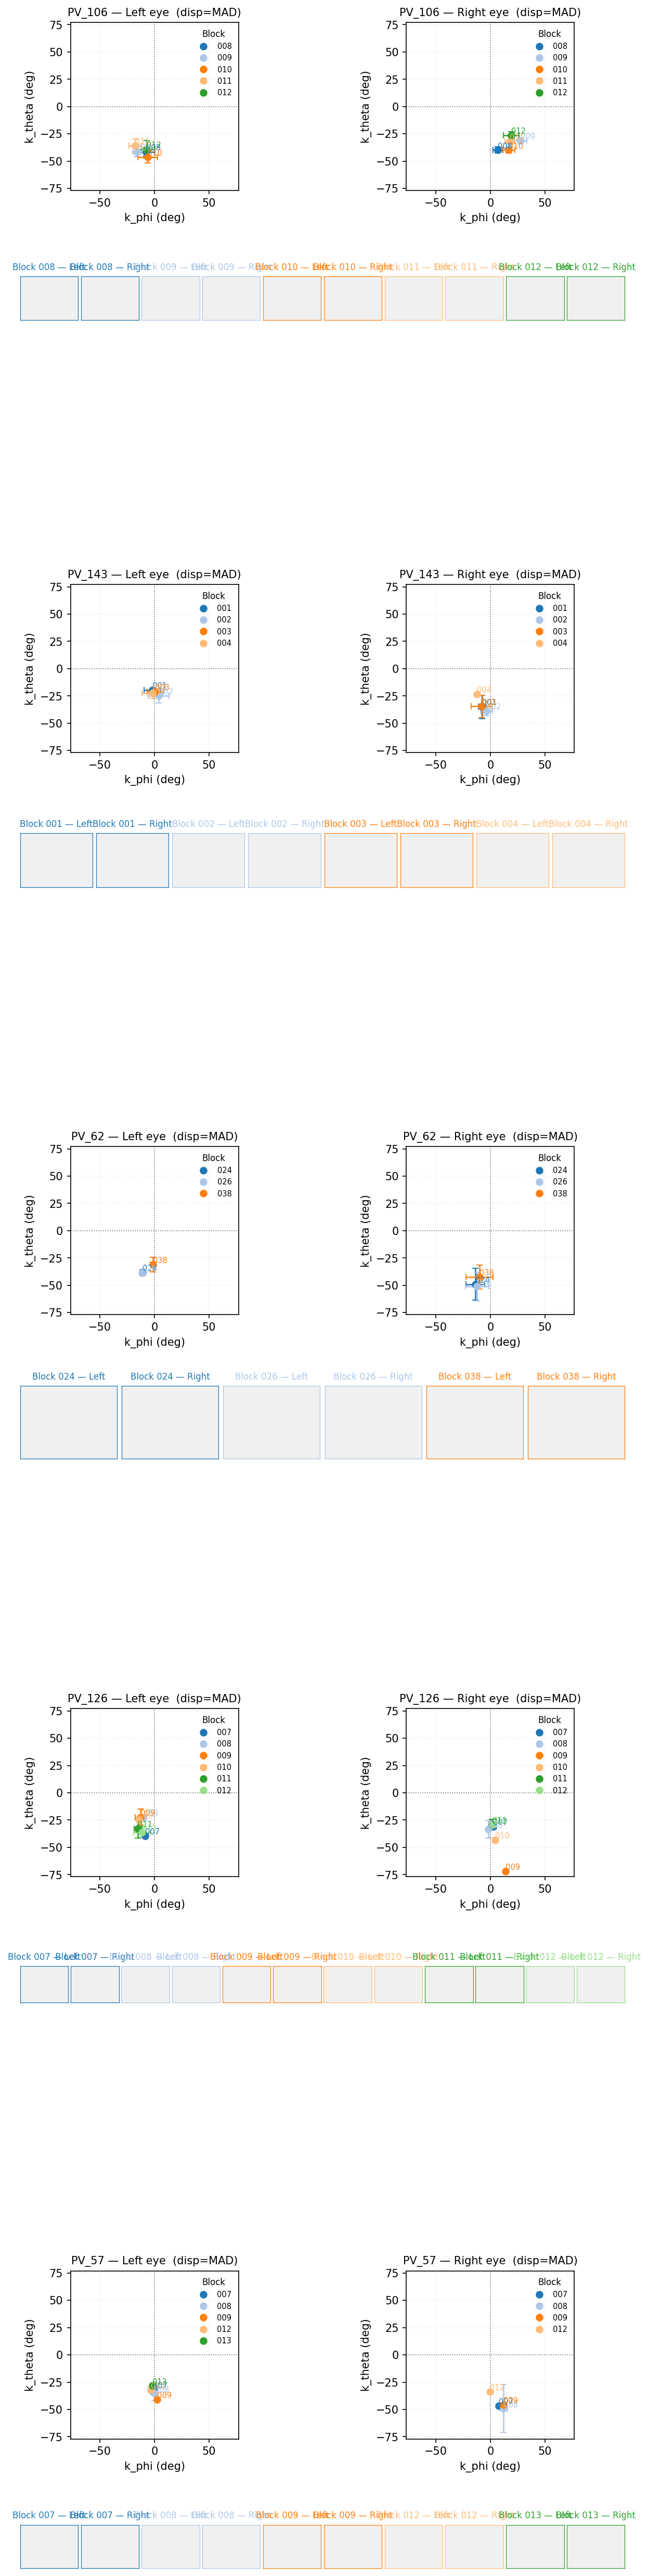

In [15]:
summary_df, fig = plot_rest_positions_phi_theta_scatter_with_frames(
    block_dict,
    eyes=('L','R'),
    rest_filter=True,
    speed_quantile=0.20,
    min_segment_ms=250,
    dispersion='MAD',            # or 'IQR'
    per_plot_size=(4.6,4.6),
    zero_lines=True,
    include_frames=True,
    frame_strategy='median_rest',
    max_blocks_images=None,      # e.g., 6 to cap wide animals
    export_path=None             # e.g., pathlib.Path(r"Z:\Nimrod\exports")
)
display(summary_df.head())
plt.show()


In [6]:
def create_saccade_events_with_direction_segmentation_robust(
        eye_data_df,
        speed_threshold,  # angular speed threshold in degrees/frame
        directional_delta_threshold_deg=25,  # threshold for change in instantaneous angle (degrees)
        magnitude_calib=1,
        speed_profile=True,
        min_subsaccade_samples=2,
        min_net_disp=0.5  # minimal net angular displacement (in degrees) for a segment to be valid
):
    """
    Detects and segments saccade events in eye tracking data using angular speed and directional changes.
    This robust version avoids producing segments with near-zero net displacement by:
      1. Defining the saccade onset as the first frame where the angular speed exceeds the threshold.
      2. Segmenting the event based on sustained directional changes.
      3. Discarding segments whose overall net angular displacement (computed from k_phi and k_theta)
         is below a user-specified minimal value.

    Parameters:
      - eye_data_df (pd.DataFrame): DataFrame with columns including:
            'center_x', 'center_y', 'k_phi', 'k_theta', 'OE_timestamp', 'ms_axis', 'pupil_diameter'.
      - speed_threshold (float): Angular speed threshold (degrees/frame) for detection.
      - directional_delta_threshold_deg (float): Angular change threshold to determine segmentation boundaries.
      - magnitude_calib (float): Calibration factor (not applied to angular measures).
      - speed_profile (bool): Whether to record speed profiles.
      - min_subsaccade_samples (int): Minimum number of samples required for a valid segment.
      - min_net_disp (float): Minimal net angular displacement (in degrees) required for a segment to be kept.

    Returns:
      - df (pd.DataFrame): The input DataFrame with added computed columns.
      - saccade_events_df (pd.DataFrame): DataFrame listing detected and segmented saccade events, with metrics.
    """
    # Make a copy so as not to modify the original DataFrame.
    df = eye_data_df.copy()

    ### 1. Compute Frame-to-Frame Differences
    df["speed_x"] = df["center_x"].diff()
    df["speed_y"] = df["center_y"].diff()
    df["speed_r"] = np.sqrt(df["speed_x"] ** 2 + df["speed_y"] ** 2)

    # Angular differences (k_phi and k_theta are in degrees)
    df["angular_speed_phi"] = df["k_phi"].diff()
    df["angular_speed_theta"] = df["k_theta"].diff()
    df["angular_speed_r"] = np.sqrt(df["angular_speed_phi"] ** 2 + df["angular_speed_theta"] ** 2)

    ### 2. Saccade Detection Based on Angular Speed
    # Mark frames where the instantaneous angular speed exceeds the threshold.
    df["is_saccade_angle"] = df["angular_speed_r"] > speed_threshold

    # Identify transitions to detect onsets and offsets.
    saccade_on_off = df["is_saccade_angle"].astype(int) - df["is_saccade_angle"].shift(1, fill_value=0).astype(int)
    # Use the first frame above threshold as onset
    saccade_on_inds = np.where(saccade_on_off == 1)[0]
    saccade_off_inds = np.where(saccade_on_off == -1)[0]

    # Handle mismatches: if a saccade starts but does not end, drop the last onset.
    if len(saccade_on_inds) > len(saccade_off_inds):
        saccade_on_inds = saccade_on_inds[:-1]

    saccade_events = []

    ### 3. Process Each Detected Saccade for Segmentation
    for start_ind, end_ind in zip(saccade_on_inds, saccade_off_inds):
        saccade_df = df.iloc[start_ind:end_ind + 1].copy()
        if saccade_df.empty or len(saccade_df) < min_subsaccade_samples:
            continue

        # Compute instantaneous angles (for both pixel- and angular-based estimates)
        saccade_df["inst_angle_pixel"] = np.degrees(np.arctan2(saccade_df["speed_y"], saccade_df["speed_x"]))
        saccade_df["inst_angle_deg"] = np.degrees(
            np.arctan2(saccade_df["angular_speed_theta"], saccade_df["angular_speed_phi"]))

        # Define helper function for minimal angular difference (handling circularity)
        minimal_angle_diff_deg = lambda a, b: ((a - b + 180) % 360) - 180

        angles = saccade_df["inst_angle_deg"].values
        # Compute consecutive differences
        angle_diffs = np.array([minimal_angle_diff_deg(angles[i + 1], angles[i]) for i in range(len(angles) - 1)])

        # Identify candidate segmentation boundaries when the absolute change exceeds threshold.
        candidate_boundaries = np.where(np.abs(angle_diffs) > directional_delta_threshold_deg)[0].tolist()

        # Always include the first and last frame of the saccade.
        boundaries = [0] + candidate_boundaries + [len(saccade_df) - 1]

        # Process each segment defined by these boundaries.
        for i in range(len(boundaries) - 1):
            seg_start = boundaries[i]
            seg_end = boundaries[i + 1]
            subsaccade = saccade_df.iloc[seg_start: seg_end + 1]
            if len(subsaccade) < min_subsaccade_samples:
                continue

            # Compute net angular displacement using the angular positions (k_phi and k_theta)
            initial_pos_angle = subsaccade.iloc[0][["k_phi", "k_theta"]]
            final_pos_angle = subsaccade.iloc[-1][["k_phi", "k_theta"]]
            net_disp = np.sqrt((final_pos_angle["k_phi"] - initial_pos_angle["k_phi"]) ** 2 +
                               (final_pos_angle["k_theta"] - initial_pos_angle["k_theta"]) ** 2)

            # Only record segments whose net displacement is above min_net_disp.
            if net_disp < min_net_disp:
                continue

            # Timing and indices
            sub_start_timestamp = subsaccade["OE_timestamp"].iloc[0]
            sub_end_timestamp = subsaccade["OE_timestamp"].iloc[-1]
            sub_start_ms = subsaccade["ms_axis"].iloc[0]
            sub_end_ms = subsaccade["ms_axis"].iloc[-1]
            sub_length = subsaccade.index[-1] - subsaccade.index[0]

            # Pixel-based metrics
            magnitude_raw_pixel = subsaccade["speed_r"].sum()
            magnitude_pixel = magnitude_raw_pixel * magnitude_calib

            # Angular-based metric: sum of instantaneous angular speeds
            magnitude_raw_angular = subsaccade["angular_speed_r"].sum()

            # Overall angular-based angle (from start to end)
            overall_angle_deg = (np.degrees(np.arctan2(
                final_pos_angle["k_theta"] - initial_pos_angle["k_theta"],
                final_pos_angle["k_phi"] - initial_pos_angle["k_phi"]
            )) % 360)

            # (Optional) Capture speed profiles and other details
            speed_profile_pixel = subsaccade["speed_r"].values if speed_profile else None
            speed_profile_pixel_calib = (speed_profile_pixel * magnitude_calib) if speed_profile else None
            speed_profile_angular = subsaccade["angular_speed_r"].values if speed_profile else None
            diameter_profile = subsaccade["pupil_diameter"].values

            saccade_events.append({
                "saccade_start_ind": subsaccade.index[0],
                "saccade_end_ind": subsaccade.index[-1],
                "saccade_start_timestamp": sub_start_timestamp,
                "saccade_end_timestamp": sub_end_timestamp,
                "saccade_on_ms": sub_start_ms,
                "saccade_off_ms": sub_end_ms,
                "length": sub_length,
                "magnitude_raw_pixel": magnitude_raw_pixel,
                "magnitude_pixel": magnitude_pixel,
                "magnitude_raw_angular": magnitude_raw_angular,
                "overall_angle_deg": overall_angle_deg,
                "net_angular_disp": net_disp,
                "speed_profile_pixel": speed_profile_pixel,
                "speed_profile_pixel_calib": speed_profile_pixel_calib,
                "speed_profile_angular": speed_profile_angular,
                "diameter_profile": diameter_profile,
                "theta_init_pos": initial_pos_angle["k_theta"],
                "theta_end_pos": final_pos_angle["k_theta"],
                "phi_init_pos": initial_pos_angle["k_phi"],
                "phi_end_pos": final_pos_angle["k_phi"]
            })

    # Convert the list to a DataFrame.
    saccade_events_df = pd.DataFrame(saccade_events)

    # Optionally remove intermediate column
    df.drop(["is_saccade_angle"], axis=1, inplace=True)

    # Calculate delta columns for convenience.
    if not saccade_events_df.empty:
        saccade_events_df['delta_theta'] = saccade_events_df['theta_end_pos'] - saccade_events_df['theta_init_pos']
        saccade_events_df['delta_phi'] = saccade_events_df['phi_end_pos'] - saccade_events_df['phi_init_pos']

    return df, saccade_events_df


In [7]:
for block in block_collection:
    print(block)
    block.left_eye_data, block.l_saccade_df = create_saccade_events_with_direction_segmentation_robust(block.left_eye_data,
                                                                                                        0.8,  # angular speed threshold in degrees/video frame
                                                                                                        directional_delta_threshold_deg=90,  # threshold for change in instantaneous angle (degrees)
                                                                                                        magnitude_calib=1,
                                                                                                        speed_profile=True,
                                                                                                        min_subsaccade_samples=2)
    block.right_eye_data, block.r_saccade_df = create_saccade_events_with_direction_segmentation_robust(block.right_eye_data,
                                                                                                        0.8,  # angular speed threshold in degrees/video frame
                                                                                                        directional_delta_threshold_deg=90,  # threshold for change in instantaneous angle (degrees)
                                                                                                        magnitude_calib=1,
                                                                                                        speed_profile=True,
                                                                                                        min_subsaccade_samples=2)


PV_106, block 008, on PV106_ET_d3t12025-08-06_11-52-19
PV_106, block 009, on PV106_ET_d3t2_2025-08-06_12-09-43
PV_106, block 010, on PV106_ET_d3t3_2025-08-06_12-26-43
PV_106, block 011, on PV106_ET_d3t4_2025-08-06_12-44-30
PV_106, block 012, on PV106_ET_d3t5_2025-08-06_13-21-30
PV_143, block 001, on PV143_ET_d1t1_2025-08-11_13-29-08
PV_143, block 002, on PV143_ET_d1t2_2025-08-11_13-50-11
PV_143, block 003, on PV143_ET_d1t3_2025-08-11_14-20-35
PV_143, block 004, on PV143_ET_d1t4_2025-08-11_14-58-28
PV_62, block 024, on 2023-04-27_11-22-56
PV_62, block 026, on 2023-04-27_12-21-41
PV_62, block 038, on 2023-05-01_13-57-45
PV_126, block 007, on PV126_Trial16_wake3_2024-07-18_12-49-12
PV_126, block 008, on PV126_Trial16_wake4_2024-07-18_13-24-41
PV_126, block 009, on PV126_Trial18_wake5_2024-07-18_14-39-15
PV_126, block 010, on PV126_Trial19_wake6_2024-07-18_15-24-57
PV_126, block 011, on PV126_Trial115_eyeTracking_w7
PV_126, block 012, on PV126_Trial116_eyeTracking_h8
PV_57, block 007, on p

In [8]:
### over here, I get the lizard movements binary from mark's analysis
import os
def block_get_lizard_movement(block):
    p = block.oe_path / 'analysis'
    analysis_list = os.listdir(p)
    correct_analysis = [i for i in analysis_list if block.animal_call in i][0]
    p = p / str(correct_analysis)
    mat_path = p / 'lizMov.mat'
    print(f'path to mat file is {mat_path}')
    # read mat file
    try:
        mat_data = h5py.File(str(mat_path), 'r')
        mat_dict = {'t_mov_ms': mat_data['t_mov_ms'][:],
                    'movAll': mat_data['movAll'][:],
                    'angles': mat_data['angles'][:],
                    'staticAll': mat_data['staticAll'][:],
                    't_static_ms': mat_data['t_static_ms'][:]}
        mat_dict['phi_rad'] = mat_dict['angles'][:,0]
        mat_dict['theta_rad'] = mat_dict['angles'][:,1]
        mat_dict['theta_deg'] = np.rad2deg(mat_dict['theta_rad'])
        mat_dict['phi_deg'] = np.rad2deg(mat_dict['phi_rad'])
        acc_df = pd.DataFrame(data=np.array([mat_dict['t_mov_ms'][:, 0], mat_dict['movAll'][:, 0]]).T,
                              columns=['t_mov_ms', 'movAll'])
        static_df = pd.DataFrame(data=np.array([mat_dict['t_static_ms'][:, 0],
                                                mat_dict['staticAll'][:, 0],
                                                mat_dict['phi_rad'],
                                                mat_dict['theta_rad'],
                                                mat_dict['phi_deg'],
                                                mat_dict['theta_deg']]).T,
                              columns=['t_static_ms', 'staticAll','phi_rad','theta_rad','phi_deg','theta_deg'])
        mat_data.close()
        block.liz_mov_df = acc_df
        block.liz_static_df = static_df
        print(f'liz_mov_df created for {block}')
    except FileNotFoundError:
        print(f'no such file {mat_path}')


# this cell now labels the saccades as with/without head movements
def get_head_mov_col(df, mov_times):
    head_mov_bool = np.zeros(len(df), dtype=bool)  # Initialize array of False

    for i, saccade in enumerate(df.itertuples()):
        saccade_start = saccade.saccade_on_ms
        saccade_end = saccade.saccade_off_ms

        overlapping_mov_times = mov_times[np.logical_and(mov_times >= saccade_start, mov_times <= saccade_end)]

        if overlapping_mov_times.size > 0:
            head_mov_bool[i] = True

    df['head_movement'] = head_mov_bool
    return df

def label_saccade_movements(block):
    mov_times = block.liz_mov_df.t_mov_ms.values
    block.l_saccade_df = get_head_mov_col(block.l_saccade_df,mov_times=mov_times)
    block.r_saccade_df = get_head_mov_col(block.r_saccade_df,mov_times=mov_times)

# Create a list to store blocks where movement data exists
block_collection_w_mov = []

for block in block_collection:
    try:
        block_get_lizard_movement(block)  # Try loading movement data
        label_saccade_movements(block)    # Try labeling saccades

        # If both steps succeed, add block to the valid collection
        block_collection_w_mov.append(block)

    except (FileNotFoundError, OSError) as e:
        print(f"Skipping block {block}: {str(e)}")  # Notify which block failed


path to mat file is Z:\Nimrod\experiments\PV_106\2025_08_06\block_008\oe_files\PV106_ET_d3t12025-08-06_11-52-19\Record Node 102\analysis\recNames=Block008,Animal=PV_106\lizMov.mat
liz_mov_df created for PV_106, block 008, on PV106_ET_d3t12025-08-06_11-52-19
path to mat file is Z:\Nimrod\experiments\PV_106\2025_08_06\block_009\oe_files\PV106_ET_d3t2_2025-08-06_12-09-43\Record Node 102\analysis\recNames=Block009,Animal=PV_106\lizMov.mat
liz_mov_df created for PV_106, block 009, on PV106_ET_d3t2_2025-08-06_12-09-43
path to mat file is Z:\Nimrod\experiments\PV_106\2025_08_06\block_010\oe_files\PV106_ET_d3t3_2025-08-06_12-26-43\Record Node 102\analysis\recNames=Block010,Animal=PV_106\lizMov.mat
liz_mov_df created for PV_106, block 010, on PV106_ET_d3t3_2025-08-06_12-26-43
path to mat file is Z:\Nimrod\experiments\PV_106\2025_08_06\block_011\oe_files\PV106_ET_d3t4_2025-08-06_12-44-30\Record Node 102\analysis\recNames=Block011,Animal=PV_106\lizMov.mat
liz_mov_df created for PV_106, block 011,

In [9]:
import os
import pickle
import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.ticker import MultipleLocator
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

def plot_saccade_magnitude_vs_velocity_time_to_peak_angular(
    synced_saccade_collection, monocular_saccade_collection, export_path=None, threshold=3,
    fig_size=(3, 3), velocity_threshold=None, velocity_to_deg_per_ms=True, frame_rate_fps=60
):
    """
    Plots angular saccade magnitudes versus angular peak velocities as a compact scatter plot.
    Angular metrics are extracted from the synchronized saccade DataFrame:
      - Angular amplitude is taken from 'magnitude_raw_angular'
      - Peak angular velocity is computed as the maximum value from 'speed_profile_angular'
      - Time-to-peak is assumed to be stored in 'time_to_peak_v'

    Parameters:
      - synced_saccade_collection: DataFrame of synchronized saccades containing angular columns.
      - monocular_saccade_collection: DataFrame of monocular saccades (unused here, but kept for compatibility).
      - export_path (str): Directory path to export the plot and data.
      - threshold (float): Standard deviation threshold for outlier removal.
      - fig_size (tuple): Figure size (width, height).
      - velocity_threshold (float): Optional horizontal line value for peak velocities.
      - velocity_to_deg_per_ms (bool): If True, convert angular speeds from deg/frame to deg/ms.
      - frame_rate_fps (float): Frame rate in frames per second.
    """

    def extract_saccade_metrics_time_to_peak_angular(saccade_collection, eye_label):
        """
        Extracts angular saccade metrics for the given eye.
        Assumes that saccade_collection contains:
          - 'magnitude_raw_angular': angular amplitude (deg)
          - 'speed_profile_angular': list/array of angular speeds (deg/frame)
          - 'time_to_peak_v': time to reach peak angular speed (ms)
        """
        filtered_data = saccade_collection.query('eye == @eye_label')
        magnitudes = filtered_data['magnitude_raw_angular'].values
        # Compute peak angular speed (in deg/frame) from the angular speed profile
        peak_velocities = np.array([np.nanmax(profile) for profile in filtered_data['speed_profile_angular']])
        time_to_peak = filtered_data['time_to_peak_v'].values
        return magnitudes, peak_velocities, time_to_peak

    # Get metrics for left and right eyes
    l_magnitudes, l_peak_velocities, l_time_to_peak = extract_saccade_metrics_time_to_peak_angular(synced_saccade_collection, 'L')
    r_magnitudes, r_peak_velocities, r_time_to_peak = extract_saccade_metrics_time_to_peak_angular(synced_saccade_collection, 'R')

    # Concatenate the data from both eyes
    all_magnitudes = np.concatenate((l_magnitudes, r_magnitudes))
    all_peak_velocities = np.concatenate((l_peak_velocities, r_peak_velocities))
    all_time_to_peaks = np.concatenate((l_time_to_peak, r_time_to_peak))

    # Convert from deg/frame to deg/ms if requested
    frame_duration = 1000 / frame_rate_fps  # ms per frame
    if velocity_to_deg_per_ms:
        all_peak_velocities = all_peak_velocities / frame_duration

    # Combine into DataFrame
    data = pd.DataFrame({
        'magnitude': all_magnitudes,           # Angular amplitude in degrees
        'peak_velocity': all_peak_velocities,   # Angular peak velocity in deg/ms
        'time_to_peak': all_time_to_peaks         # Time to peak (ms)
    })

    # Remove outliers (this function should be defined elsewhere)
    cleaned_data = remove_outliers_from_df(data, threshold)

    # Extract cleaned data for plotting
    f_magnitudes = cleaned_data['magnitude'].values
    f_peak_velocities = cleaned_data['peak_velocity'].values
    f_time_to_peaks = cleaned_data['time_to_peak'].values

    # Create scatter plot
    fig, ax = plt.subplots(figsize=fig_size, dpi=300)
    sc = ax.scatter(f_magnitudes, f_peak_velocities, s=0.7, c=f_time_to_peaks, cmap='viridis', alpha=0.7)

    ax.set_xlabel('Angular Amplitude [deg]', fontsize=10)
    ax.set_ylabel('Peak Angular Velocity [deg/ms]', fontsize=10)
    ax.tick_params(axis='both', which='major', labelsize=8)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.xaxis.set_major_locator(MultipleLocator(1))
    ax.set_xlim(left=0)
    ax.set_ylim(bottom=0)

    if velocity_threshold is not None:
        ax.axhline(y=velocity_threshold, color='red', linestyle='--', linewidth=1.5)

    # Add a limiting slope line (here, a line with slope = 1/frame_duration as a reference)
    limiting_slope = 1 / frame_duration
    x_line = np.linspace(0, f_magnitudes.max(), 100)
    y_line = limiting_slope * x_line
    ax.plot(x_line, y_line, color='orange', linestyle='--', linewidth=1.5, label='Min Detectable Speed')
    ax.legend(fontsize=8)

    # Add colorbar for time-to-peak
    cbar = plt.colorbar(sc, ax=ax, pad=0.02, aspect=10)
    cbar.set_label('Time-To-Peak [ms]', fontsize=8)
    cbar.ax.tick_params(labelsize=8)

    # Export plot and data if export_path is provided
    if export_path is not None:
        timestamp = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
        full_export_path = os.path.join(export_path, f"saccade_magnitude_vs_velocity_time_to_peak_angular_{timestamp}")
        os.makedirs(full_export_path, exist_ok=True)
        pdf_file = os.path.join(full_export_path, "saccade_magnitude_vs_velocity_time_to_peak_angular.pdf")
        fig.savefig(pdf_file, format='pdf', bbox_inches='tight', dpi=300)
        data_file = os.path.join(full_export_path, "cleaned_saccade_data_time_to_peak_angular.pkl")
        with open(data_file, 'wb') as f:
            pickle.dump(cleaned_data, f)
        print(f"Exported plot and data to: {full_export_path}")

    plt.show()


In [10]:
# add annotations for a joint dataframe:
for block in block_collection:
    block.r_saccade_df['eye'] = 'R'
    block.r_saccade_df['block'] = block.block_num
    block.r_saccade_df['animal'] = block.animal_call
    block.l_saccade_df['eye'] = 'L'
    block.l_saccade_df['block'] = block.block_num
    block.l_saccade_df['animal'] = block.animal_call
    block.all_saccade_df = pd.concat([block.l_saccade_df,block.r_saccade_df])

In [11]:
saccade_df_list = []
for block in block_collection:
    saccade_df_list.append(block.all_saccade_df)
saccade_collection = pd.concat(saccade_df_list)

In [12]:
def get_closest_diff_ind(timestamp, timeseries):
    """
    This function extracts a frame from a series so that it is as close as possible to a given timestamp
    :param timestamp: The time to match a frame to
    :param timeseries: The time frames series to look at for a match
    :param report_acc: if set to 1, will report the accuracy of the match
    :return: index_of_lowest_diff , accuracy of match (if requested)
    """
    array = np.abs(timeseries - timestamp)
    index_of_lowest_diff = np.argmin(array)
    lowest_diff_val = timeseries[index_of_lowest_diff]
    return index_of_lowest_diff, lowest_diff_val

def find_synced_saccades(df, diff_threshold=680):
    synced_saccades = []
    non_synced_saccades = []
    l_df = df.query('eye == "L"')
    r_df = df.query('eye == "R"')
    for i, row in tqdm.tqdm(l_df.iterrows()):
        l_timestamp = row['saccade_start_timestamp']
        ind_min_diff, r_timestamp = get_closest_diff_ind(l_timestamp, r_df['saccade_start_timestamp'].values)
        #print(i,ind_lowest_diff)
        time_diff = np.abs(l_timestamp - r_timestamp)
        if time_diff < diff_threshold:
            synced_saccades.append((row, r_df.iloc[ind_min_diff]))  # Collect synchronized rows
        else:
            non_synced_saccades.append(row)  # Collect non-synchronized rows
    # Create DataFrame with multi-index
    multi_index = pd.MultiIndex.from_tuples([(i, 'L') for i in range(len(synced_saccades))] + [(i, 'R') for i in range(len(synced_saccades))], names=['Main', 'Sub'])
    synced_df = pd.DataFrame(index=multi_index, columns=df.columns)
    # Populate DataFrame
    for idx, (l_row, r_row) in enumerate(synced_saccades):
        synced_df.loc[(idx, 'L')] = l_row
        synced_df.loc[(idx, 'R')] = r_row
    r_non_synced_leftovers = r_df[~r_df['saccade_start_timestamp'].isin(synced_df.query('eye == "R"')['saccade_start_timestamp'].values)]
    print(len(r_non_synced_leftovers),len(r_df))
    # Create DataFrame for non-synced saccades
    non_synced_df = pd.DataFrame(non_synced_saccades, columns=df.columns)
    non_synced_df = pd.concat([non_synced_df,r_non_synced_leftovers])

    return synced_df, non_synced_df

synced_df_list = []
non_synced_df_list = []
for saccade_df in saccade_df_list:
    # Find synced saccades:
    synced_df, non_synced_df = find_synced_saccades(saccade_df.dropna(), diff_threshold=680)
    if len(non_synced_df.dropna()) + len(synced_df.dropna()) == len(saccade_df.dropna()):
        print('got them all')

    synced_df_list.append(synced_df)
    non_synced_df_list.append(non_synced_df)


924it [00:00, 7391.48it/s]
395it [00:00, 6322.68it/s]
472it [00:00, 10075.12it/s]

105 517
102 336



1273it [00:00, 8137.68it/s]


103 320


724it [00:00, 9273.48it/s]
0it [00:00, ?it/s]

377 961
333 650


519it [00:00, 6618.28it/s]
322it [00:00, 6884.36it/s]
0it [00:00, ?it/s]

234 565
145 320


387it [00:00, 4141.46it/s]
265it [00:00, 8373.63it/s]
675it [00:00, 7303.25it/s]

256 495
93 207



623it [00:00, 7976.96it/s]
0it [00:00, ?it/s]

262 638
374 761


1090it [00:00, 7750.05it/s]
774it [00:00, 7082.41it/s]

1071 1649


1409it [00:00, 7520.25it/s]
429it [00:00, 6847.96it/s]
192it [00:00, 12360.23it/s]

435 1315
289 541
317 458



271it [00:00, 8664.07it/s]
381it [00:00, 3474.42it/s]

183 353


1056it [00:00, 4828.09it/s]
112it [00:00, 7221.33it/s]
934it [00:00, 7456.03it/s]

539 1251
53 123



949it [00:00, 6765.22it/s]


1635 2183


794it [00:00, 7255.79it/s]

461 1087



786it [00:00, 7190.77it/s]

487 888



999it [00:00, 6394.03it/s]

286 763


573 1245


In [13]:
def combine_synced_dataframes(dataframes):
    combined_dfs = []
    start_index = 0
    for df in dataframes:
        num_rows = len(df) // 2  # Assuming each dataframe contains pairs of rows
        main_index = pd.MultiIndex.from_tuples([(i + start_index, 'L') for i in range(num_rows)] + [(i + start_index, 'R') for i in range(num_rows)], names=['Main', 'Sub'])
        df.index = main_index
        combined_dfs.append(df)
        start_index += num_rows
    combined_df = pd.concat(combined_dfs)
    combined_df.reset_index(inplace=True)
    return combined_df

synced_saccade_collection = combine_synced_dataframes(synced_df_list)
non_synced_saccade_collection = pd.concat(non_synced_df_list)


In [14]:
all_saccade_collection = pd.concat([synced_saccade_collection,non_synced_saccade_collection])
